In [15]:
# Install the required packages

import sys
!{sys.executable} -m pip install matplotlib

import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
# Import the required packages for the model

import torch
import torch.nn as nn
import torch.optim as optim

# Define the Siamese Network architecture
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.fc1 = nn.Linear(1024, 512)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(512, 512)
        self.dropout = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(p=0.2)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 1)

    def forward_once(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        x = torch.sigmoid(self.fc5(x))
        return x

    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        return out1, out2

# Define the contrastive loss function
def criterion1(output1,output2, label):
    loss = 0
    dif = output1.squeeze() - output2.squeeze()
    norm = torch.norm(dif, p=1, dim=dif.dim() - 1)
    dis = torch.exp(-norm)
    dis = torch.clamp(dis, min=1e-7, max=1.0 - 1e-7)
    criterion = nn.MSELoss()
    loss = criterion(dis, label)
    return loss



In [4]:
# Define the function to get the graph

def get_graph(data, data_test, num):
    data_same_ratio = data

    # Shuffle the data

    data_same_ratio_1 = data_same_ratio.sample(frac=1)

    # create a dataset of input pairs and labels. Data is shuffled. Define the size of the training set.

    N = 18000  #600000
    val = 2000 #100000
    test = 2000 #258156

    print("Training set size: ", N)
    # create a dataset of input pairs and labels
    input1 = torch.as_tensor(torch.from_numpy(np.vstack(data_same_ratio_1['tcr_embeds1'].iloc[:N].values)))
    input2 = torch.as_tensor(torch.from_numpy(np.vstack(data_same_ratio_1['tcr_embeds2'].iloc[:N].values)))
    labels = torch.tensor(np.transpose(data_same_ratio_1['binding'].iloc[:N].values.astype(float)))

    input1 = input1.to(torch.float32)
    input2 = input2.to(torch.float32)
    labels = labels.to(torch.float32)
    print(" input1 shape: ", input1.shape)

    print("Validation set size: ", val)
    # Validation set
    v_input1 = torch.as_tensor(torch.from_numpy(np.vstack(data_same_ratio_1['tcr_embeds1'].iloc[N:].values)))
    v_input2 = torch.as_tensor(torch.from_numpy(np.vstack(data_same_ratio_1['tcr_embeds2'].iloc[N:].values)))
    v_labels = torch.tensor(np.transpose(data_same_ratio_1['binding'].iloc[N:].values.astype(float)))

    v_input1 = v_input1.to(torch.float32)
    v_input2 = v_input2.to(torch.float32)
    v_labels = v_labels.to(torch.float32)
    print(" v_input1 shape: ", v_input1.shape)

    print("Test set size: ", test)
    # Test set
    t_input1 = torch.as_tensor(torch.from_numpy(np.vstack(data_test['tcr_embeds1'].values)))
    t_input2 = torch.as_tensor(torch.from_numpy(np.vstack(data_test['tcr_embeds2'].values)))
    t_labels = torch.tensor(np.transpose(data_test['binding'].values.astype(float)))

    t_input1 = t_input1.to(torch.float32)
    t_input2 = t_input2.to(torch.float32)
    t_labels = t_labels.to(torch.float32)
    print(" t_input1 shape: ", t_input1.shape)

    # Initialize the Siamese Network and the contrastive loss
    siamese_net = SiameseNetwork() 
    # criterion = nn.L1Loss() #L1Loss() #HingeEmbeddingLoss() #ContrastiveLoss()

    # Initialize the optimizer
    optimizer = optim.Adam(siamese_net.parameters(), lr=0.001) #0.0005

    # Initialize the loss value, number of epochs and the validation accuracy
    loss_val = 0 # loss value
    ep = 50 # number of epochs
    val_graph = []  # validation accuracy
    loss_graph = [] # loss value

    # Train the Siamese Network
    for epoch in range(ep):
        print("Epoch: ", epoch+1)
        for i in range(N):
            # Forward pass
            optimizer.zero_grad()
            output1, output2 = siamese_net(input1[i].unsqueeze(0), input2[i].unsqueeze(0)) 
            output1 = output1.squeeze() 
            output2 = output2.squeeze()

            # Compute the contrastive loss
            loss = criterion1(output1,output2, labels[i])
            
            # Backward pass
            loss.backward()
            loss_val += loss
            optimizer.step()
        
        # Evaluate the Siamese Network
        correct = 0
        total = 0
        with torch.no_grad():
            # Validation set
            for i in range(val):
                output1, output2 = siamese_net(v_input1[i].unsqueeze(0), v_input2[i].unsqueeze(0))
                output1 = output1.squeeze()
                output2 = output2.squeeze()
                euclidean_distance = torch.sqrt(torch.sum((output1 - output2)**2))
                prediction = (euclidean_distance < 0.5).long().item()
                total += 1
                correct += (prediction == v_labels[i]).long().item()

        # Graph the validation accuracy
        val_graph.append(100 * correct / total)
        loss_graph.append(loss_val.item()/N)
        print("Val Accuracy: {:.2f}% | Loss: {:.4f} | Epitope : {:.6f}".format(100 * correct / total, loss_val.item()/N, num))

    # Evaluate the Siamese Network
    correct = 0
    total = 0
    y_pred = []
    with torch.no_grad():
        for i in range(test):
            #TCR1, TCR2 = data
            output1, output2 = siamese_net(t_input1[i], t_input2[i])
            euclidean_distance = torch.sqrt(torch.sum((output1 - output2)**2))
            prediction = (euclidean_distance < 0.5).long().item()
            y_pred.append(prediction)
            total += 1
            correct += (prediction == t_labels[i]).long().item()

    print("Accuracy: {:.2f}%".format(100 * correct / total))
    #print(classification_report(t_labels, y_pred))

    
    return val_graph, loss_graph, y_pred, t_labels

In [5]:
val_g, loss_g, pred, true_labels = [], [], [], []

for i in range(1,6):
    data = pd.read_pickle('NewData/individual/trainData_20k_'+str(i)+'.pkl')
    data_test = pd.read_pickle('NewData/individual/testData_20k_'+str(i)+'.pkl')

    val_graph, loss_graph, y_pred, t_labels = get_graph(data, data_test, i)
    val_g.append(val_graph)
    loss_g.append(loss_graph)
    pred.append(y_pred)
    true_labels.append(t_labels)


Training set size:  18000
 input1 shape:  torch.Size([18000, 1024])
Validation set size:  2000
 v_input1 shape:  torch.Size([2000, 1024])
Test set size:  2000
 t_input1 shape:  torch.Size([2000, 1024])
Epoch:  1
Val Accuracy: 47.15% | Loss: 0.3282 | Epitope : 1.000000
Epoch:  2
Val Accuracy: 50.40% | Loss: 0.6514 | Epitope : 1.000000
Epoch:  3
Val Accuracy: 51.65% | Loss: 0.9652 | Epitope : 1.000000
Epoch:  4
Val Accuracy: 51.80% | Loss: 1.2811 | Epitope : 1.000000
Epoch:  5
Val Accuracy: 58.25% | Loss: 1.6173 | Epitope : 1.000000
Epoch:  6
Val Accuracy: 60.30% | Loss: 1.9460 | Epitope : 1.000000
Epoch:  7
Val Accuracy: 56.30% | Loss: 2.3030 | Epitope : 1.000000
Epoch:  8
Val Accuracy: 63.00% | Loss: 2.6777 | Epitope : 1.000000
Epoch:  9
Val Accuracy: 60.30% | Loss: 3.0461 | Epitope : 1.000000
Epoch:  10
Val Accuracy: 60.65% | Loss: 3.4100 | Epitope : 1.000000
Epoch:  11
Val Accuracy: 61.70% | Loss: 3.7824 | Epitope : 1.000000
Epoch:  12
Val Accuracy: 61.65% | Loss: 4.1672 | Epitope : 

In [8]:
pd.to_pickle(val_g,'NewData/individual/val_graph.pkl')
pd.to_pickle(loss_g,'NewData/individual/loss_graph.pkl')
pd.to_pickle(pred,'NewData/individual/pred.pkl')
pd.to_pickle(true_labels,'NewData/individual/true_labels.pkl')

In [17]:
val_g = pd.read_pickle('NewData/individual/val_graph.pkl')
loss_g = pd.read_pickle('NewData/individual/loss_graph.pkl')
pred = pd.read_pickle('NewData/individual/pred.pkl')
true_labels = pd.read_pickle('NewData/individual/true_labels.pkl')

In [21]:
file = pd.read_pickle('NewData/trainData_epi_5.pkl')
names = file['epi'].value_counts().index.tolist()


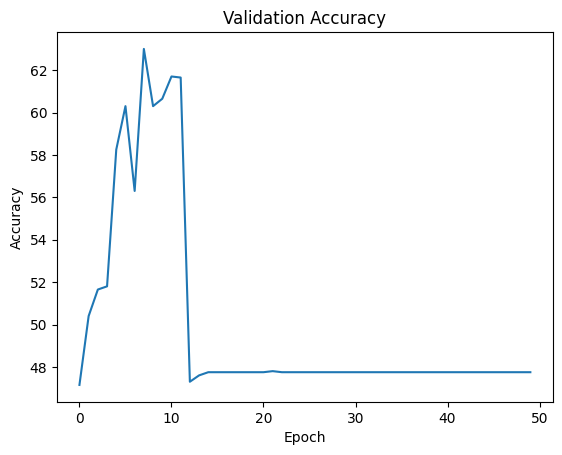

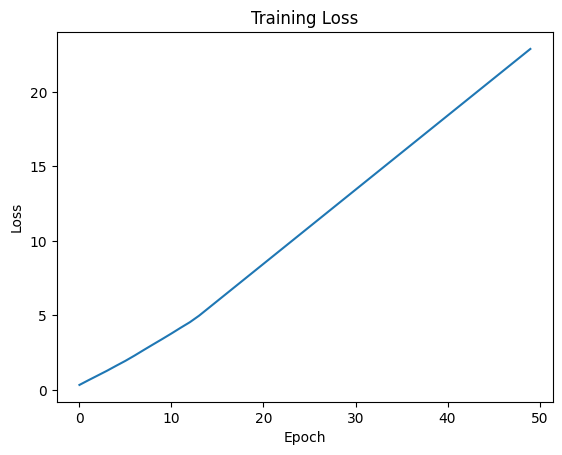

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1000
         1.0       0.50      1.00      0.67      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000



/Users/wingman2.0/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wingman2.0/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wingman2.0/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [10]:
plt.title('Validation Accuracy')
plt.plot(val_g[0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.title('Training Loss')
plt.plot(loss_g[0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print(classification_report(true_labels[0], pred[0]))

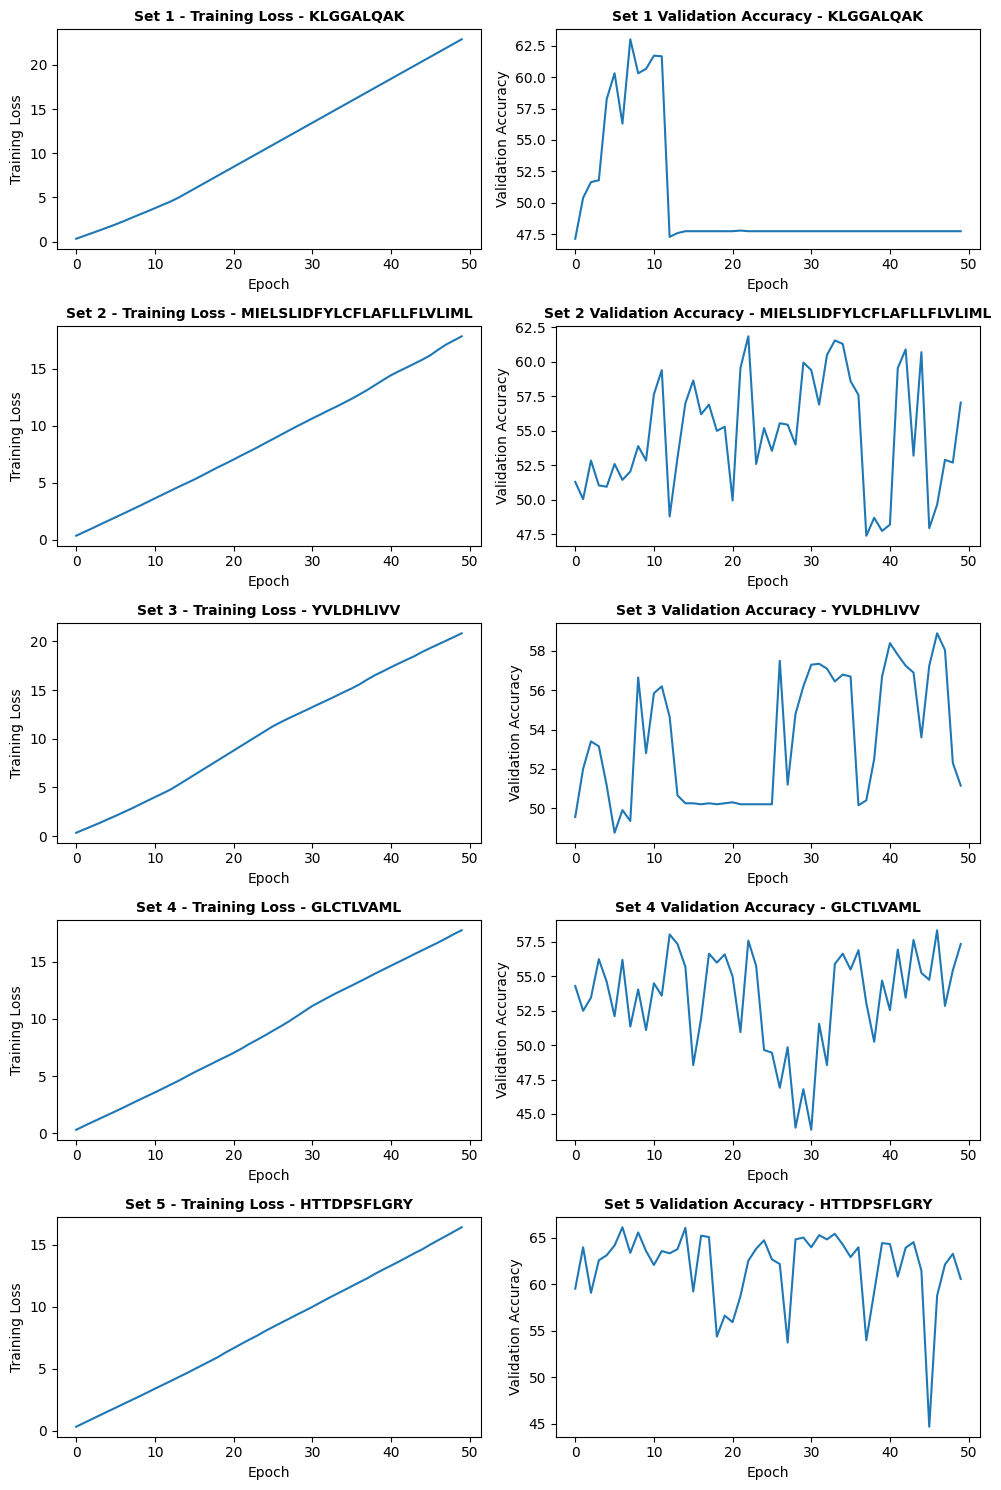

In [35]:
# create figure and subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,15))

v = 10
# plot training loss and validation accuracy for each set of data
for i in range(5):
    # plot training loss
    ax1 = axes[i,0]
    ax1.plot(loss_g[i])
    ax1.set_xlabel("Epoch", fontsize=v)
    ax1.set_ylabel("Training Loss", fontsize=v)
    ax1.set_title(f"Set {i+1} - Training Loss - {names[i]}", fontsize=v, weight='bold')
    
    # plot validation accuracy
    ax2 = axes[i,1]
    ax2.plot(val_g[i])
    ax2.set_xlabel("Epoch", fontsize=v)
    ax2.set_ylabel("Validation Accuracy", fontsize=v)
    ax2.set_title(f"Set {i+1} Validation Accuracy - {names[i]}", fontsize=v, weight='bold')

    # # adjust layout and show plot

    # report = classification_report(true_labels[0], pred[0], output_dict=True)
    # report_str = ""
    # for k, v in report.items():
    #     if k != "accuracy":
    #         report_str += f"{k.capitalize()}: \n{v}\n\n"
    # ax2.text(1.1, 0.5, report_str, fontsize=12, transform=ax2.transAxes)


plt.tight_layout()
plt.show()

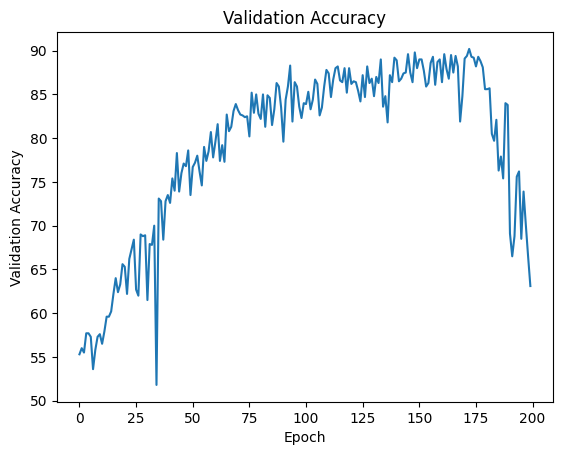

In [10]:
plt.title('Validation Accuracy')
plt.plot(val_graph)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()


In [37]:
# Evaluate the Siamese Network
correct = 0
total = 0
ouyput_data = []
with torch.no_grad():
    for i in range(test):
        #TCR1, TCR2 = data
        output1, output2 = siamese_net(t_input1[i], t_input2[i])
        euclidean_distance = torch.sqrt(torch.sum((output1 - output2)**2))
        prediction = (euclidean_distance < 0.5).long().item()
        total += 1
        correct += (prediction == t_labels[i]).long().item()

print("Accuracy: {:.2f}%".format(100 * correct / total))


Accuracy: 50.50%


In [16]:
# Initialize the Siamese Network and the contrastive loss
siamese_net = SiameseNetwork() 
criterion = nn.L1Loss() #L1Loss() #HingeEmbeddingLoss() #ContrastiveLoss()

# Initialize the optimizer
optimizer = optim.Adam(siamese_net.parameters(), lr=0.001) #0.0005

# Initialize the loss value, number of epochs and the validation accuracy
loss_val = 0 # loss value
ep = 100 # number of epochs
val_graph = []  # validation accuracy

# Train the Siamese Network
for epoch in range(ep):
    print("====================== epoch "+str(epoch+1))
    for i in range(N):
        # Forward pass
        optimizer.zero_grad()
        output1, output2 = siamese_net(input1[i].unsqueeze(0), input2[i].unsqueeze(0)) 
        #output1 = output1.squeeze() 
        #output2 = output2.squeeze()

        # Compute the contrastive loss
        loss = criterion1(output1,output2, labels[i])
        
        # Backward pass
        loss.backward()
        loss_val += loss
        optimizer.step()
    
    # Evaluate the Siamese Network
    correct = 0
    total = 0
    with torch.no_grad():
        # Validation set
        for i in range(val):
            output1, output2 = siamese_net(v_input1[i].unsqueeze(0), v_input2[i].unsqueeze(0))
            #output1 = output1.squeeze()
            output2 = output2.squeeze()
            euclidean_distance = torch.sqrt(torch.sum((output1 - output2)**2))
            prediction = (euclidean_distance < 0.5).long().item()
            total += 1
            correct += (prediction == v_labels[i]).long().item()

    # Graph the validation accuracy
    val_graph.append(100 * correct / total)
    print("Val Accuracy: {:.2f}%".format(100 * correct / total))
    print("Loss: {:.4f}".format(loss_val.item()/N))
    loss_val = 0

plt.title('Validation Accuracy')
plt.plot(val_graph)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.show()


====================== epoch 1
Val Accuracy: 50.75%
Loss: 0.3424
====================== epoch 2
Val Accuracy: 50.35%
Loss: 0.3348
====================== epoch 3
Val Accuracy: 49.75%
Loss: 0.3471
====================== epoch 4
Val Accuracy: 49.85%
Loss: 0.3483
====================== epoch 5
Val Accuracy: 49.45%
Loss: 0.3691
====================== epoch 6
Val Accuracy: 51.60%
Loss: 0.4140
====================== epoch 7
Val Accuracy: 49.25%
Loss: 0.4019
====================== epoch 8
Val Accuracy: 49.95%
Loss: 0.4372
====================== epoch 9
Val Accuracy: 50.30%
Loss: 0.4746
====================== epoch 10
Val Accuracy: 50.75%
Loss: 0.5003
====================== epoch 11
Val Accuracy: 50.80%
Loss: 0.5009
====================== epoch 12
Val Accuracy: 50.80%
Loss: 0.5009
====================== epoch 13
Val Accuracy: 50.80%
Loss: 0.5009
====================== epoch 14


KeyboardInterrupt: 